# Sparkify Churn Prediction

### This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

## Table of Contents

I. [Load and Clean the Dataset](#load_and_clean)<br>
II. [Exploratory Data Analysis](#eda)<br>
III. [Feature Engineering](#feature_engineering)<br>
IV. [Modeling](#modeling)<br>
V. [Conclusion](#conclusion)<br>

In [303]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, isnull, count, countDistinct, sum as Fsum
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StandardScaler, VectorAssembler
from IPython.display import HTML
import re
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from time import time

In [80]:
# create a Spark session
spark = SparkSession \
       .builder \
       .appName("Sparkify") \
       .getOrCreate()

## <a class="anchor" id="load_and_clean">Part I : Load and Clean the Dataset</a>

In [81]:
# load the small json file (128Mb)
sparkify_data = 'Data/mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [82]:
# check first rows of the dataframe
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [83]:
# get dataframe schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Clean the dataset
#### Observations
* While investigating any NaN values in userId and sessionId columns, one can see there are no NULL values, but instead there are 'blank' values for userId's
* Those 'blank' userId's are most likely assigned to the newcomers that not yet have an account on the sparkify platform
#### Decisions on current observations
* Our initial goal is to predict if user will churn or not therefore, deciding to get rid of userId rows where userId == ''

In [84]:
# number of rows in the dataframe
df.count()

286500

In [85]:
# drop nulls
df = df.dropna(how = 'any'
              ,subset = ['userId','sessionId'])
df.count()

286500

In [8]:
# closer look at userId column
df.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [9]:
# check if there are any null values in the sessionId column
df.select('sessionId').dropDuplicates().sort('sessionId').show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [11]:
# check number of empty string userId's
df.select('userId').where(df['userId'] == '').agg(count('*')).show()

+--------+
|count(1)|
+--------+
|    8346|
+--------+



In [12]:
# it looks like 'blank' userId's refer to visitors or newcomers to sparkify website  
df.select('userId','page').dropDuplicates().where(df['userId'] == '').show()

+------+-------------------+
|userId|               page|
+------+-------------------+
|      |               Home|
|      |              Error|
|      |           Register|
|      |Submit Registration|
|      |              About|
|      |              Login|
|      |               Help|
+------+-------------------+



In [86]:
# filter out those users from the dataframe
df = df.filter(df["userId"] != "")
# check number of rows after initial cleansing
df.count()

278154

## <a class="anchor" id="eda">Part II : Exploratory Data Analysis</a>

In [87]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Preliminary analysis
#### Let's see some statistics related to the time series.

In [88]:
# get date and time values from epoch 
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%-H"))
get_weekday_number = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
get_weekday_name = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%A"))
get_month_number = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%-m"))
get_month_name = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%B"))

In [89]:
# creating columns with easy to read date and time values for further analysis
df = df.withColumn("hour", get_hour(df['ts']))
df = df.withColumn("weekdaynumber", get_weekday_number(df['ts']))
df = df.withColumn("weekday", get_weekday_name(df['ts']))
df = df.withColumn("monthnumber", get_month_number(df['ts']))
df = df.withColumn("month", get_month_name(df['ts']))

In [92]:
# check first row
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', weekdaynumber='1', weekday='Monday', monthnumber='10', month='October')]

#### Observations
* By investigating hourly distribution of songs listened, one can clearly see pattern, where most of sparkify users are online and listen to the music in the afteroon.
* This information could help us decide when to send any promotion emails to maximize potential interaction with the email or any other sort of communication from our platform.
* From week day volume we can spot difference between weekend activity and resto of the week.
* Finally monthly distribution doesn't tell us anything, as our small sample contains only two months of data.

In [94]:
# check number of songs by hour
songs_in_hour = df.filter(df.page == "NextSong").groupby(df['hour']).count().orderBy(df['hour'].cast("float")).toPandas()
songs_in_hour['hour'] = songs_in_hour['hour'].astype('int')

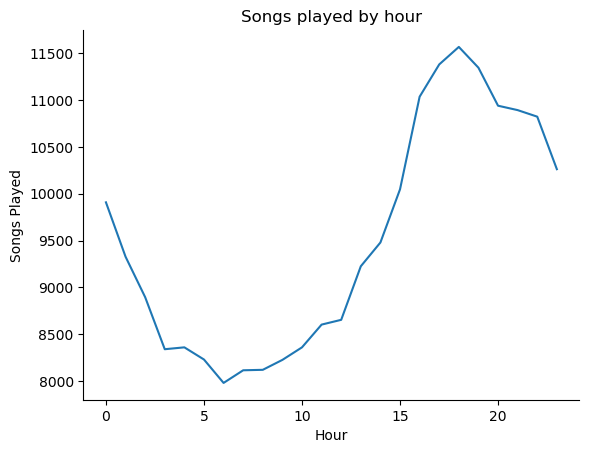

In [233]:
# plot the results
ax = sns.lineplot(data = songs_in_hour
                ,x = 'hour'
                ,y = 'count')
plt.xlabel('Hour')
plt.ylabel('Songs Played')
plt.title('Songs played by hour')
sns.despine(ax = ax)

In [96]:
# check distribution of songs played by week day
songs_in_day = df.filter(df.page == "NextSong").groupby(['weekdaynumber','weekday']).count().sort('weekdaynumber').toPandas()
songs_in_day

,weekdaynumber,weekday,count
0,0,Sunday,17513
1,1,Monday,34044
2,2,Tuesday,38370
3,3,Wednesday,38551
4,4,Thursday,36015
5,5,Friday,39456
6,6,Saturday,24159


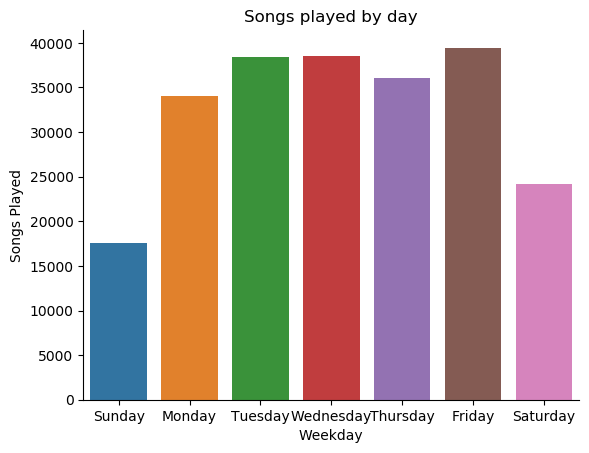

In [232]:
# plot the results
ax = sns.barplot(data = songs_in_day
                ,x = 'weekday'
                ,y = 'count')
plt.xlabel('Weekday')
plt.ylabel('Songs Played')
plt.title('Songs played by day')
sns.despine(ax = ax)

In [99]:
# check number of songs played by month
songs_in_month = df.filter(df.page == "NextSong").groupby(['monthnumber','month']).count().orderBy(df['monthnumber'].cast("float")).toPandas()
songs_in_month

,monthnumber,month,count
0,10,October,117934
1,11,November,110043
2,12,December,131


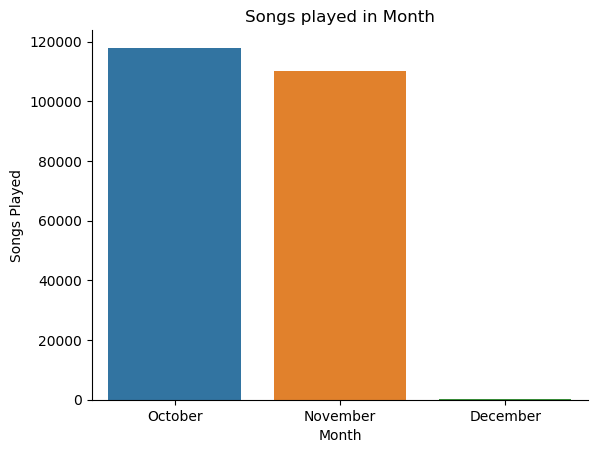

In [231]:
# plot the results
ax = sns.barplot(data = songs_in_month
                ,x = 'month'
                ,y = 'count')
plt.xlabel('Month')
plt.ylabel('Songs Played')
plt.title('Songs played in Month')
sns.despine(ax = ax)

In [200]:
# check distinct values in page column 
df.select('page').dropDuplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [220]:
# get volume of activities 
activities = df.groupby('page').count().sort('page').toPandas()
print(activities)
# exclude NextSong from the final results (most of the user log activities are realted to the next song event)
activities_final = activities[activities['page'] != 'NextSong']

page   count
0                       About     495
1                  Add Friend    4277
2             Add to Playlist    6526
3                      Cancel      52
4   Cancellation Confirmation      52
5                   Downgrade    2055
6                       Error     252
7                        Help    1454
8                        Home   10082
9                      Logout    3226
10                   NextSong  228108
11                Roll Advert    3933
12              Save Settings     310
13                   Settings    1514
14           Submit Downgrade      63
15             Submit Upgrade     159
16                Thumbs Down    2546
17                  Thumbs Up   12551
18                    Upgrade     499


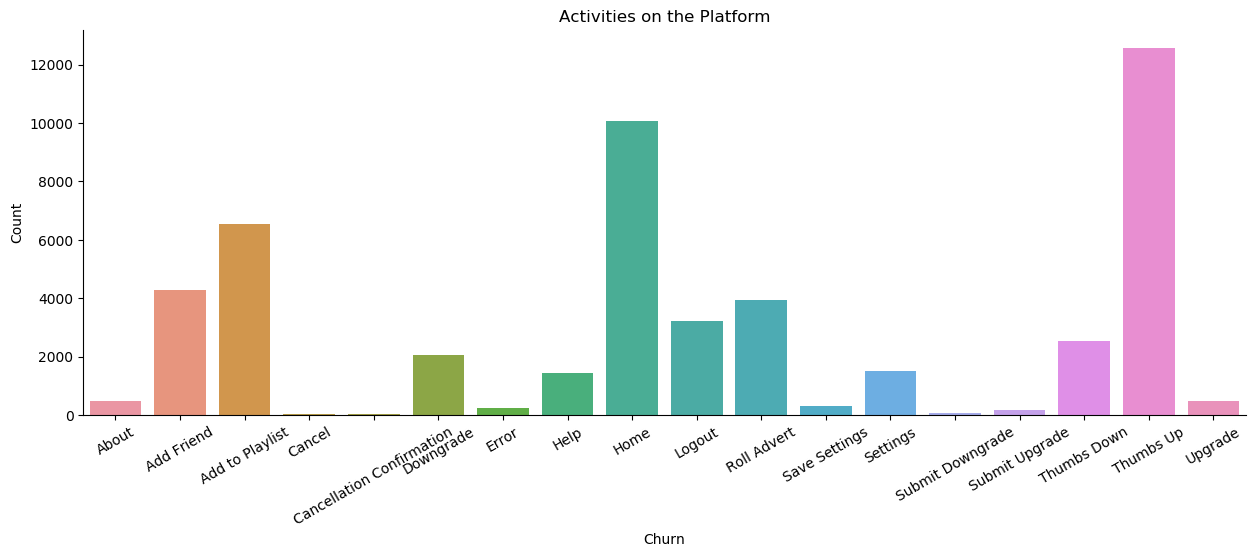

In [221]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data = activities_final
                ,x = 'page'
                ,y = 'count')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Activities on the Platform')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
sns.despine(ax = ax)

### Define Churn based on cancellation confirmation

In [101]:
# flag the records related to the cancellation and downgrade events
flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
flag_cancelation_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())

In [102]:
# create two new columns and applying functions
df = df.withColumn('churn', flag_cancelation_event('page'))
df = df.withColumn('downgrade', flag_downgrade_event('page'))

In [103]:
# check if all went all right
df.head(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', weekdaynumber='1', weekday='Monday', monthnumber='10', month='October', churn=0, downgrade=0)]

In [104]:
# partitioning by userId and flag 1 for true and 0 for false
windowval = Window.partitionBy('userId')
df = df.withColumn('churn', max('churn').over(windowval))
df = df.withColumn('downgrade', max('downgrade').over(windowval))

In [105]:
# check label columns grouped by userId
df.select(['userId','churn','downgrade']).dropDuplicates().sort('userId').show()

+------+-----+---------+
|userId|churn|downgrade|
+------+-----+---------+
|    10|    0|        0|
|   100|    0|        1|
|100001|    1|        0|
|100002|    0|        0|
|100003|    1|        0|
|100004|    0|        1|
|100005|    1|        0|
|100006|    1|        0|
|100007|    1|        0|
|100008|    0|        1|
|100009|    1|        1|
|100010|    0|        0|
|100011|    1|        0|
|100012|    1|        1|
|100013|    1|        0|
|100014|    1|        0|
|100015|    1|        1|
|100016|    0|        1|
|100017|    1|        0|
|100018|    0|        1|
+------+-----+---------+
only showing top 20 rows



In [106]:
# check shape [0]
df.count()

278154

In [107]:
# check specific userId with churned == 1 and downgraded == 0 (free user)
df.select(['userId','firstname','page','level','churn','downgrade']).dropDuplicates().where(df['userId'] == '100001').collect()

[Row(userId='100001', firstname='Delaney', page='Home', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='NextSong', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='Roll Advert', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='Logout', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='Thumbs Down', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='Add Friend', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='Thumbs Up', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='Add to Playlist', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='Settings', level='free', churn=1, downgrade=0),
 Row(userId='100001', firstname='Delaney', page='Upgrade', level='free', churn=1, downgrade=0),
 Row(userId='100001',

In [108]:
# check paid user that churned 
df.select(['userId','firstname','page','level','churn','downgrade']).dropDuplicates().where(df['userId'] == '100015').collect()

[Row(userId='100015', firstname='Tina', page='NextSong', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Roll Advert', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Add to Playlist', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Home', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Add Friend', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Logout', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Settings', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Thumbs Up', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Thumbs Down', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Upgrade', level='free', churn=1, downgrade=1),
 Row(userId='100015', firstname='Tina', page='Help'

### Label EDA
#### Observations
* Sample data contains large imbalance between churned and not churned users (this might and most likely will affect our model predicting capabilities)

In [109]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- weekdaynumber: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- monthnumber: string (nullable = true)
 |-- month: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- downgrade: integer (nullable = true)



In [198]:
# how many users are out there
df.select('userId').dropDuplicates().agg(count('userId')).show()

+-------------+
|count(userId)|
+-------------+
|          225|
+-------------+



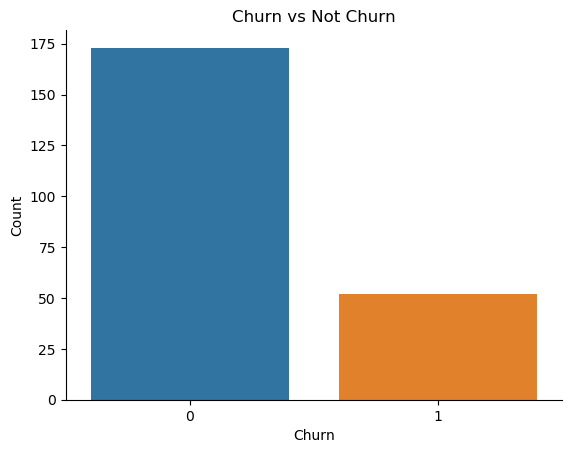

In [230]:
# user churned and not churned
churn_not_churn = df.groupby('churn').agg(countDistinct('userId').alias('count')).toPandas()
ax = sns.barplot(data = churn_not_churn
                ,x = 'churn'
                ,y = 'count')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.title('Churn vs Not Churn')
sns.despine(ax = ax)

In [42]:
df.select('userID','page','length').where(df['userId'] == '125').collect()

[Row(userID='125', page='NextSong', length=337.91955),
 Row(userID='125', page='NextSong', length=230.03383),
 Row(userID='125', page='NextSong', length=203.2322),
 Row(userID='125', page='NextSong', length=210.83383),
 Row(userID='125', page='NextSong', length=391.26159),
 Row(userID='125', page='NextSong', length=213.60281),
 Row(userID='125', page='NextSong', length=178.41587),
 Row(userID='125', page='NextSong', length=323.81342),
 Row(userID='125', page='Roll Advert', length=None),
 Row(userID='125', page='Cancel', length=None),
 Row(userID='125', page='Cancellation Confirmation', length=None)]

#### Observations on total songs listened
* Overall users that do not churn tend to listen more songs. There could be couple of reasons behind it.
    1. User seniority. We can suspect that loyal users are much longer on sparkify platform, therefore overall more time for listening to the music.
    2. User preference. Demographically speaking there could be difference in user behavior that is happy with the platform compare to the user that is just checking it out.

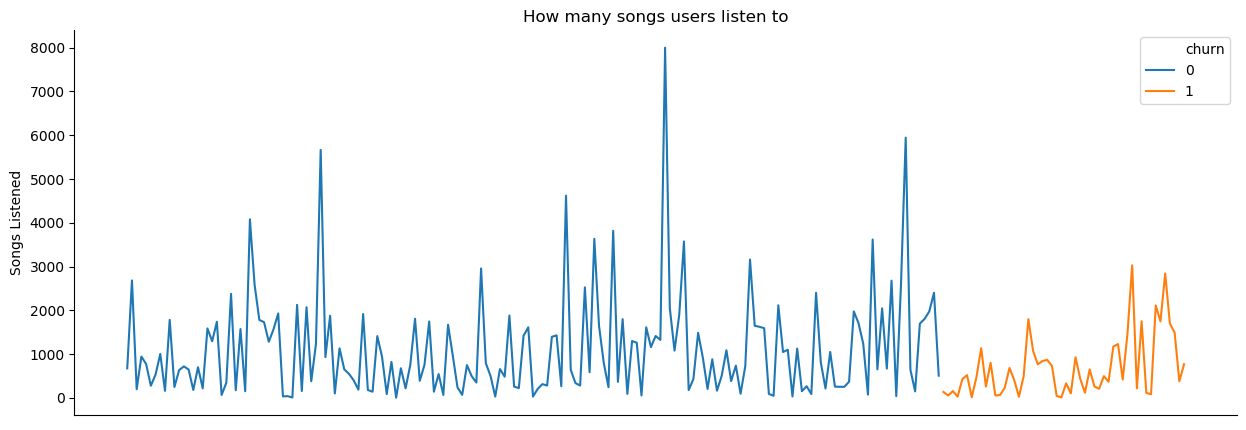

In [168]:
# Total songs listened
songs_listened = df.select('userId','page','churn').where(df['page'] == 'NextSong').groupBy(['userId','churn']).count().withColumnRenamed('count', 'total_songs').toPandas()
plt.figure(figsize=(15,5))
ax = sns.lineplot(data = songs_listened
                 ,x = 'userId'
                 ,y = 'total_songs'
                 ,hue = 'churn')
plt.xlabel('')                 
plt.ylabel('Songs Listened')
plt.title('Total number of songs listened')
ax.set_xticks([])
sns.despine(ax = ax)

#### Observations on likes given
* Users that do not churn tend to give more likes than churned users

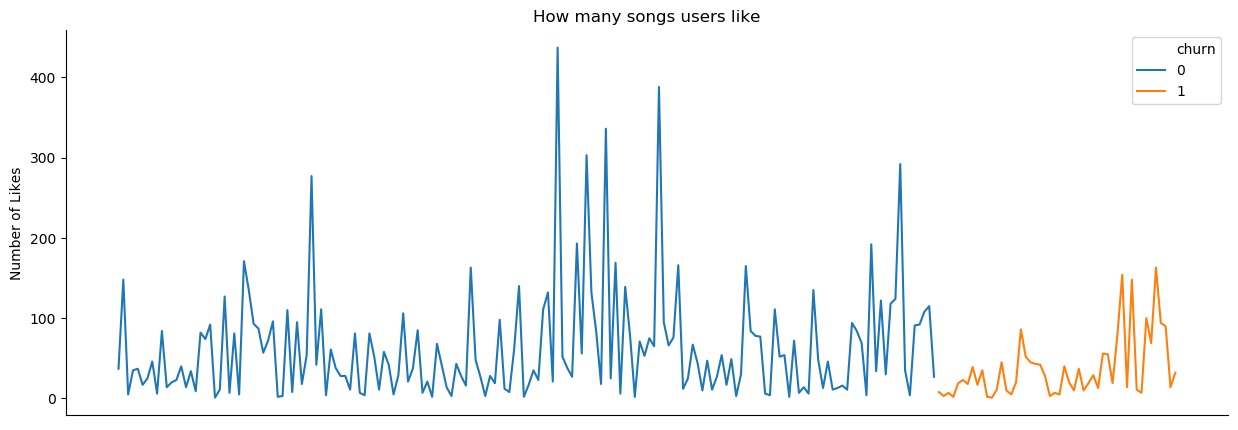

In [171]:
# Songs liked
songs_liked = df.select('userId','page','churn').where(df['page'] == 'Thumbs Up').groupBy(['userId','churn']).count().withColumnRenamed('count', 'total_thumbs_up').toPandas()
plt.figure(figsize=(15,5))
ax = sns.lineplot(data = songs_liked
                 ,x = 'userId'
                 ,y = 'total_thumbs_up'
                 ,hue = 'churn')
plt.xlabel('')
plt.ylabel('Number of Likes')
plt.title('How many songs users like')
ax.set_xticks([])
sns.despine(ax = ax)

#### Observations on dislikes given
* There is clear difference between likes given and dislikes given in churned users. Users that do churn and have relatively low level on total songs listened, giving large amount of displikes.<br>
  This discovery is a whole new subject to investigate and would require from us to investigate newcomers and their personalities, with that we could decide on completely new marketing campaign only for these users.

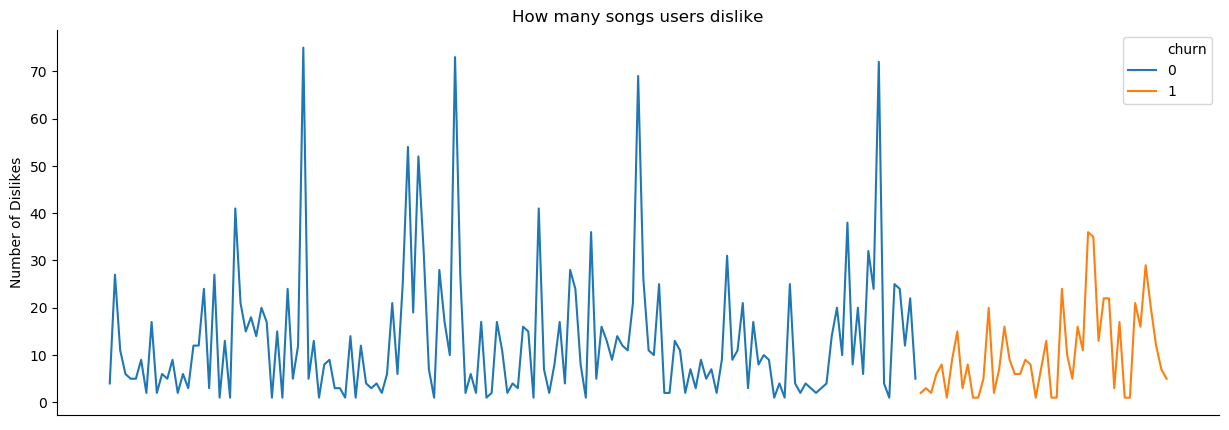

In [189]:
# Songs disliked
songs_disliked = df.select('userId','page','churn').where(df['page'] == 'Thumbs Down').groupBy(['userId','churn']).count().withColumnRenamed('count', 'total_thumbs_down').toPandas()
plt.figure(figsize=(15,5))
ax = sns.lineplot(data = songs_disliked
                 ,x = 'userId'
                 ,y = 'total_thumbs_down'
                 ,hue = 'churn')
plt.xlabel('')
plt.ylabel('Number of Dislikes')
plt.title('How many songs users dislike')
ax.set_xticks([])
sns.despine(ax = ax)


#### Observations on dislikes given
* Not churned users tend to have constant level of platform usage and average songs listened by session. (Of course there are some outliers)

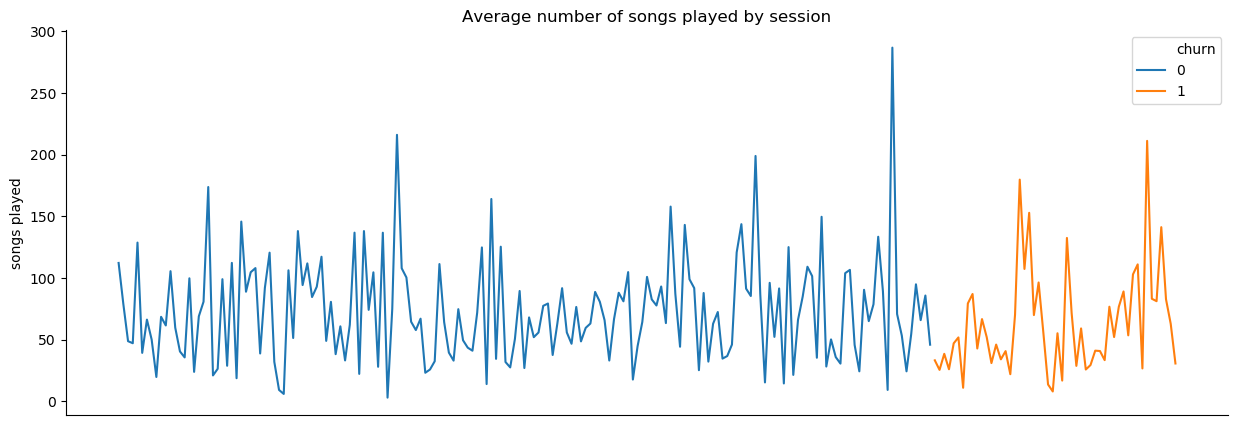

In [191]:
# calculate average number of songs played by sesssion
average_songs = df.where('page == "NextSong"').groupby(['userId', 'sessionId','churn']).count().groupby(['userId','churn']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played').toPandas()
plt.figure(figsize=(15,5))
ax = sns.lineplot(data = average_songs
                 ,x = 'userId'
                 ,y = 'avg_songs_played'
                 ,hue = 'churn')
plt.xlabel('')
plt.ylabel('songs played')
plt.title('Average number of songs played by session')
ax.set_xticks([])
sns.despine(ax = ax)

### Gender EDA
#### Observations
* Suprisingly males are higher number on sparkify platform

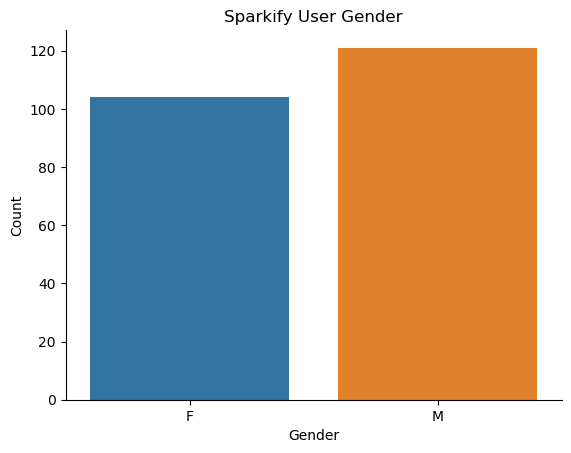

In [196]:
# check the distribution of gender 
gender_dist = df.groupby(df['gender']).agg(countDistinct('userId').alias('count')).toPandas()
ax = sns.barplot(data = gender_dist
                ,x = 'gender'
                ,y = 'count')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Sparkify User Gender')
sns.despine(ax = ax)

#### Observations
* Percentage-wise females are more likely to churn

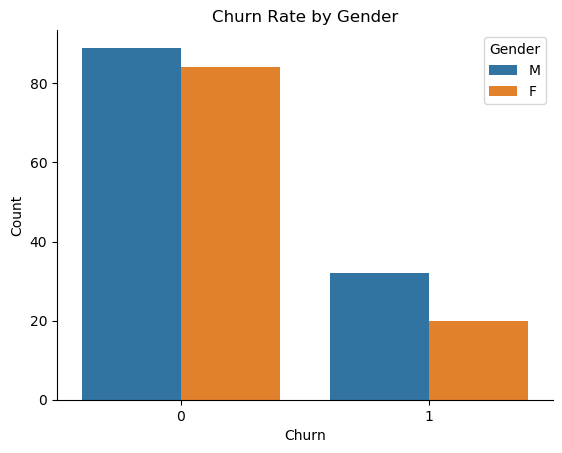

In [197]:
# churn not churn by gender
gender_churn = df.groupby(['gender','churn']).agg(countDistinct('userId').alias('count')).toPandas()
ax = sns.barplot(data = gender_churn
                ,x = 'churn'
                ,y = 'count'
                ,hue = 'gender')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title = 'Gender'
          ,loc = 'best')
plt.title('Churn Rate by Gender')
sns.despine(ax = ax)

In [224]:
gender_df = df.where('page == "NextSong" OR page == "Thumbs Up" or page == "Thumbs Down"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
gender_df = gender_df.pivot_table(index = ['userId','churn','gender']
                                                         ,values = 'count'
                                                         ,columns = 'page').reset_index()
gender_df.columns = gender_df.columns.str.replace(' ', '_')
gender_df

page,userId,churn,gender,NextSong,Thumbs_Down,Thumbs_Up
0,10,0,M,673.0,4.0,37.0
1,100,0,M,2682.0,27.0,148.0
2,100001,1,F,133.0,2.0,8.0
3,100002,0,F,195.0,NaN,5.0
4,100003,1,F,51.0,NaN,3.0
...,...,...,...,...,...,...
220,95,0,F,1694.0,25.0,91.0
221,96,0,F,1802.0,24.0,92.0
222,97,0,F,1975.0,12.0,108.0
223,98,0,M,2401.0,22.0,115.0


#### Observations churn by gender plots
* There is a significant difference between males that churn and not churn, where churned cases show less interest in the platform.
* Females and males tend to like less songs than users who are loyal to the platform.
* Female users show tendency towards disliking songs before churning.

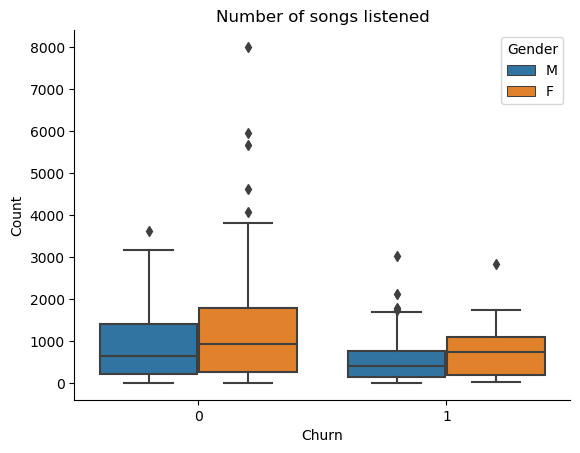

In [225]:
# songs listened by gender and label
ax = sns.boxplot(data = gender_df
                ,x = 'churn'
                ,y = 'NextSong'
                ,hue = 'gender')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title = 'Gender'
          ,loc = 'best')
plt.title('Number of songs listened')
sns.despine(ax = ax)

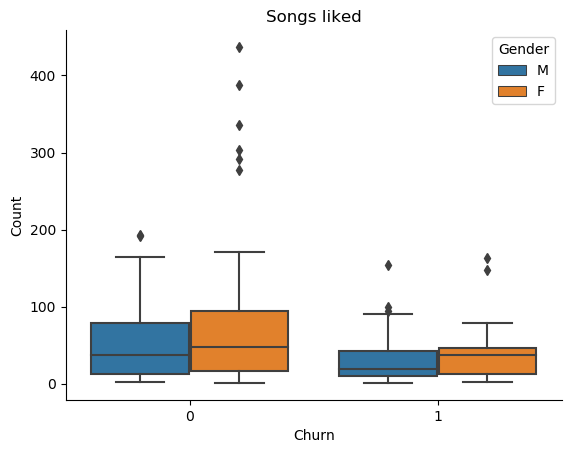

In [227]:
# songs liked by gender and label
ax = sns.boxplot(data = gender_df
                ,x = 'churn'
                ,y = 'Thumbs_Up'
                ,hue = 'gender')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title = 'Gender'
          ,loc = 'best')
plt.title('Songs liked')
sns.despine(ax = ax)

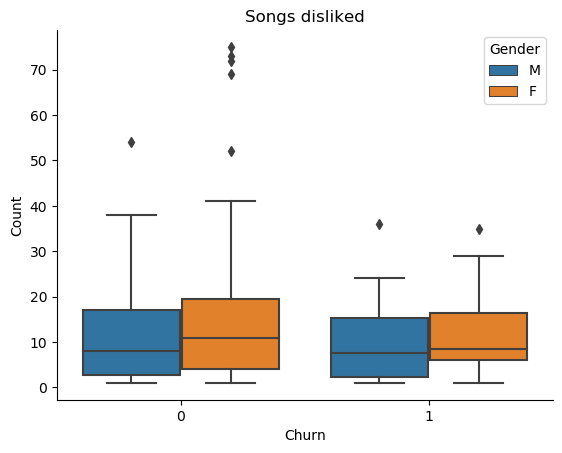

In [229]:
ax = sns.boxplot(data = gender_df
                ,x = 'churn'
                ,y = 'Thumbs_Down'
                ,hue = 'gender')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.legend(title = 'Gender'
          ,loc = 'best')
plt.title('Songs disliked')
sns.despine(ax = ax)

## <a class="anchor" id="feature_engineering">Part III : Feature Engineering</a>

### 1. Total songs listened feature
#### Explainign the decision
* First and it seems the most important feature to include is the number of songs users listened during their lifetime on the platform. <br>
  This feature potentially explains seniority, activity and general interest in the platform.

In [243]:
# songs listened
songs_listened = df \
                .select('userId', 'page') \
                .where(df['page'] == 'NextSong') \
                .groupBy('userId') \
                .count() \
                .withColumnRenamed('count', 'songs_listened')
songs_listened.describe().show()

+-------+------------------+------------------+
|summary|            userId|    songs_listened|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|1013.8133333333334|
| stddev|105396.47791907164|1104.9607785540886|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+



### 2. Seniority feature
#### Explaining the decision
* It appears logical to include seniority. More senior users are most likely the loyal ones, on another hand newcomers might be just checking things out.

In [244]:
# seniority 
seniority = df \
            .select('userId', 'registration', 'ts') \
            .withColumn('lifetime',(df['ts'] - df['registration'])) \
            .groupBy('userId') \
            .agg({'lifetime':'max'}) \
            .withColumnRenamed('max(lifetime)','seniority') \
            .select('userId', (col('seniority')/1000/3600/24).alias('seniority'))
seniority.describe().show()

+-------+------------------+-------------------+
|summary|            userId|          seniority|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



### 3. Songs added to playlist feature
#### Explaining the decision
* We can assume that, users who build their personal playlists have interest in using them. They spend time and effort to cutomize platform to their needs.

In [245]:
# songs in playlist
playlist = df \
          .select('userId','page') \
          .where(df['page'] == 'Add to Playlist') \
          .groupBy('userId') \
          .count() \
          .withColumnRenamed('count', 'songs_in_playlist')
playlist.describe().show()

+-------+------------------+-----------------+
|summary|            userId|songs_in_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



### 4. Likes given feature
#### Explaining the decision
* Exploratory data analysis have presented strong evidence on difference between likes and dislikes given and likelyhood of cancelling the subscription.

In [246]:
# likes
likes = df \
       .select('userId','page') \
       .where(df.page == 'Thumbs Up') \
       .groupBy('userId') \
       .count() \
       .withColumnRenamed('count', 'likes_given')
likes.describe().show()       

+-------+------------------+-----------------+
|summary|            userId|      likes_given|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



### 5. Dislikes given feature

In [247]:
# dislikes
dislikes = df \
          .select('userId','page') \
          .where(df['page'] == 'Thumbs Down') \
          .groupBy('userId') \
          .count() \
          .withColumnRenamed('count', 'dislikes_given')
dislikes.describe().show()

+-------+------------------+------------------+
|summary|            userId|    dislikes_given|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



### 6. Total listening time feature
#### Explaining the decision
* It seems like listening time corresponds to the total number of songs listened, although we should take into consideration users that listen only podcasts. This user will have low number of songs listened but large time spent listening to something. 

In [248]:
# listening time
total_listening = df \
                 .select('userId','length') \
                 .groupBy('userId') \
                 .sum() \
                 .withColumnRenamed('sum(length)', 'listen_time')
total_listening.describe().show()

+-------+------------------+------------------+
|summary|            userId|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155555|
| stddev|105396.47791907164| 275396.4038847638|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799998|
+-------+------------------+------------------+



### 7. Friends added feature
#### Explaining the decision
* It might be a good idea to see if user shares his/her experience with friends. We all can agree that, enjoying something with your loved ones counts as two.

In [249]:
# friends added
friends = df \
         .select('userID','page') \
         .where(df['page'] == 'Add Friend') \
         .groupBy('userID') \
         .count() \
         .withColumnRenamed('count', 'add_friend') 
friends.describe().show()

+-------+------------------+------------------+
|summary|            userID|        add_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



### 8. Gender feature
#### Explaining the decision
* Expensive data analysis proved us the significance of gender on decision to churn or not to.

In [250]:
# gender
gender = df \
        .select("userId", "gender") \
        .dropDuplicates() \
        .replace(['M', 'F'], ['0', '1'], 'gender') \
        .select('userId', col('gender').cast('int'))
gender.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



### 9. Average songs listened by session feature
#### Explaining the decision
* Average activity should show decent importance on churn, not churn outcome. Simply put, constant activity is better than spikes of activity.

In [251]:
# songs by session
songs_by_session = df.where('page == "NextSong"') \
                  .groupby(['userId', 'sessionId']) \
                  .count() \
                  .groupby(['userId']) \
                  .agg({'count':'avg'}) \
                  .withColumnRenamed('avg(count)', 'avg_songs_by_session')
songs_by_session.describe().show()

+-------+------------------+--------------------+
|summary|            userId|avg_songs_by_session|
+-------+------------------+--------------------+
|  count|               225|                 225|
|   mean|65391.013333333336|   70.78971233958933|
| stddev|105396.47791907164|    42.6153697543817|
|    min|                10|                 3.0|
|    max|                99|   286.6666666666667|
+-------+------------------+--------------------+



### 10. Unique artists feature
#### Explaining the decision
* Some people might love media platform just because of their exclusive artists availability. Have you ever watched a movie because there is your favourite actor in it? Well... Me too.

In [252]:
# distinct artists
artists = df \
         .filter(df['page'] == "NextSong") \
         .select("userId", "artist") \
         .dropDuplicates() \
         .groupby("userId") \
         .count() \
         .withColumnRenamed("count", "artist_count")
artists.describe().show()

+-------+------------------+-----------------+
|summary|            userId|     artist_count|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



### Target column 

In [253]:
# label column
label = df \
       .select('userId', col('churn').alias('label')) \
       .dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [260]:
# join all features together 
df_final = songs_listened.join(seniority
                              ,'userId'
                              ,how = 'left') \
                         .join(playlist
                              ,'userId'
                              ,how = 'left') \
                         .join(likes
                              ,'userId'
                              ,how = 'left') \
                         .join(dislikes
                              ,'userId'
                              ,how = 'left') \
                         .join(total_listening
                              ,'userId'
                              ,how = 'left') \
                         .join(friends
                              ,'userId'
                              ,how = 'left') \
                         .join(gender
                              ,'userId'
                              ,how = 'left') \
                         .join(songs_by_session
                              ,'userId'
                              ,how = 'left') \
                         .join(artists
                              ,'userId'
                              ,how = 'left') \
                         .join(label
                              ,'userId'
                              ,how = 'left') \
                         .drop('userId') \
                         .fillna(0)
df_final.show(5)

+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+
|songs_listened|         seniority|songs_in_playlist|likes_given|dislikes_given|       listen_time|add_friend|gender|avg_songs_by_session|artist_count|label|
+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+
|           275|  55.6436574074074|                7|         17|             5|       66940.89735|         4|     1|  39.285714285714285|         252|    0|
|           387| 70.07462962962963|                8|         21|             6| 94008.87593999993|         4|     0|                64.5|         339|    0|
|             8| 71.31688657407408|                0|          0|             0|2089.1131000000005|         0|     0|                 8.0|           8|    1|
|          2111|19.455844907407407|               52

## <a class="anchor" id="modeling">Part IV : Modeling</a>


In [261]:
# vector assembler
cols = ['songs_listened'
       ,'seniority'
       ,'songs_in_playlist'
       ,'likes_given'
       ,'dislikes_given'
       ,'listen_time'
       ,'add_friend'
       ,'gender'
       ,'avg_songs_by_session'
       ,'artist_count']
       
assembler = VectorAssembler(inputCols = cols
                           ,outputCol = "num_features")
df_final = assembler.transform(df_final)
df_final.show()

+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+--------------------+
|songs_listened|         seniority|songs_in_playlist|likes_given|dislikes_given|       listen_time|add_friend|gender|avg_songs_by_session|artist_count|label|        num_features|
+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+--------------------+
|           275|  55.6436574074074|                7|         17|             5|       66940.89735|         4|     1|  39.285714285714285|         252|    0|[275.0,55.6436574...|
|           387| 70.07462962962963|                8|         21|             6| 94008.87593999993|         4|     0|                64.5|         339|    0|[387.0,70.0746296...|
|             8| 71.31688657407408|                0|          0|             0|2089.1131000000005|      

### Decision
* To avoid some features with larger scale dominance over the whole model, we standardize the features by taking off the mean and divided by the standard deviation of each feature.

In [262]:
# standard scaler
scaler = StandardScaler(inputCol = "num_features"
                       ,outputCol = "features"
                       ,withStd = True)
scalerModel = scaler.fit(df_final)
df_final = scalerModel.transform(df_final)
df_final.show()

+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+--------------------+--------------------+
|songs_listened|         seniority|songs_in_playlist|likes_given|dislikes_given|       listen_time|add_friend|gender|avg_songs_by_session|artist_count|label|        num_features|            features|
+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+--------------------+--------------------+
|           275|  55.6436574074074|                7|         17|             5|       66940.89735|         4|     1|  39.285714285714285|         252|    0|[275.0,55.6436574...|[0.24887761207221...|
|           387| 70.07462962962963|                8|         21|             6| 94008.87593999993|         4|     0|                64.5|         339|    0|[387.0,70.0746296...|[0.35023867589799...|


In [263]:
df_final.count()

225



Then we split the data into train, validation, and test sets by calling randomSplit method twice. We can also conduct a stratified sampling as our label is pretty skewed.


In [266]:
# train, test, validation split
train, test = df_final.randomSplit([0.8, 0.2]
                                  ,seed = 42)
print(train.count())
print(test.count())                                              

191
34


### 1. Baseline Model
* We evaluate two baseline models, one with all users labelled as churn = 1, other with all users labelled as churn = 0. And we calculated the model accuracy and f1 score.
* The reason we use F-1 score here is because it gives us a simple measure of the precision (whether we send offer to the right person) and recall (whether we miss one that we should’ve sent the offer) of the model. We want to identify those who are likely to churn and give them some special offers in trying to keep the customer, but at the same time, we do not want to send too many offers (most likely a monetary incentive) to those who are not as likely to churn and therefore wasting money and resources.

In [267]:
all_1 = test.withColumn('baseline_prediction'
                       ,lit(1.0))
all_1.show()                       

+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+--------------------+--------------------+-------------------+
|songs_listened|         seniority|songs_in_playlist|likes_given|dislikes_given|       listen_time|add_friend|gender|avg_songs_by_session|artist_count|label|        num_features|            features|baseline_prediction|
+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+--------------------+--------------------+-------------------+
|           387| 70.07462962962963|                8|         21|             6| 94008.87593999993|         4|     0|                64.5|         339|    0|[387.0,70.0746296...|[0.35023867589799...|                1.0|
|          2111|19.455844907407407|               52|        100|            21| 523275.8428000001|        28|     0|   

In [268]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "baseline_prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(all_1, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(all_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.29411764705882354
F-1 Score:0.1336898395721925


In [269]:
all_0 = test.withColumn('baseline_prediction'
                       ,lit(0.0))                     
all_0.show()

+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+--------------------+--------------------+-------------------+
|songs_listened|         seniority|songs_in_playlist|likes_given|dislikes_given|       listen_time|add_friend|gender|avg_songs_by_session|artist_count|label|        num_features|            features|baseline_prediction|
+--------------+------------------+-----------------+-----------+--------------+------------------+----------+------+--------------------+------------+-----+--------------------+--------------------+-------------------+
|           387| 70.07462962962963|                8|         21|             6| 94008.87593999993|         4|     0|                64.5|         339|    0|[387.0,70.0746296...|[0.35023867589799...|                0.0|
|          2111|19.455844907407407|               52|        100|            21| 523275.8428000001|        28|     0|   

Due to large class imbalanace we are able to get some decent accuracy on marking all users as 0's (not churned).

In [270]:
evaluator = MulticlassClassificationEvaluator(predictionCol = "baseline_prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(all_0, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(all_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.7058823529411765
F-1 Score:0.5841784989858012


#### !IMPORTANT Due to lack of time and of course money for cloud computing availability, we will go with default parameters for all four classifiers, return their accuracy and f1 scores. Only then we will do some hyperparameter tuning for making our best performing model even better.

### 2. Logistic Regression

In [273]:
# initialize classifier
lr = LogisticRegression(maxIter = 10)

# set evaluator
f1 = MulticlassClassificationEvaluator(metricName = 'f1')

# build grid
grid = ParamGridBuilder()\
      .build()

# creating cv 
cv_lr = CrossValidator(estimator = lr
                      ,evaluator = f1 # evaluating on f1 score
                      ,estimatorParamMaps = grid
                      ,numFolds = 3)

While working with BigData we need to take into account the time spent on executing tasks, therefore we will print time needed to run each of the models, accuracy and their f1 score

#### Results
* Time needed to train logistic regression model is approximately 3 minutes
* Model does pretty decent job at recognizing churn cases. with .76 accuracy and .7 f1 score

In [274]:
# check start time of the training process
start = time()
model_lr = cv_lr.fit(train)
# check end time of the training process
end = time()
print('The training process needs {} seconds!'.format(end - start))

The training process needs 177.25865483283997 seconds!


In [275]:
# results on validation set
results_lr = model_lr.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('Logistic Regression Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

Logistic Regression Metrics:
Accuracy: 0.7647058823529411
F-1 Score:0.7030812324929971


### 3. Support Vector Machine (SVM)

In [278]:
# initialize classifier
svm = LinearSVC(maxIter = 10)

# set evaluator
f1 = MulticlassClassificationEvaluator(metricName = 'f1')

# build grid
grid = ParamGridBuilder() \
      .build()

cv_svm = CrossValidator(estimator = svm
                       ,estimatorParamMaps = grid
                       ,evaluator = f1
                       ,numFolds = 3)


#### Results
* Training process took approximately 4min
* SVM model didn't do so well compared to LR. With some hyperparameter tuning it should yield better results, but as mentioned above we stick to defaults and then pick the best model for tuning.

In [279]:
start = time()
model_svm = cv_svm.fit(train)
end = time()
print('The training process took {} seconds'.format(end - start))

The training process took 224.02575588226318 seconds


In [280]:
results_svm = model_svm.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('SVM Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_svm, {evaluator.metricName: "f1"})))

SVM Metrics:
Accuracy: 0.6666666666666666
F-1 Score:0.5333333333333333


### 4. Random Forest

In [281]:
# initialize classifier
rf = RandomForestClassifier()

# set evaluator
f1 = MulticlassClassificationEvaluator(metricName = 'f1')

# build grid
grid = ParamGridBuilder() \
      .build()

cv_rf = CrossValidator(estimator = rf
                       ,estimatorParamMaps = grid
                       ,evaluator = f1
                       ,numFolds = 3)                          

#### Results
* RF took less than 3 min to train + it has great metric scores. Do we already have a winner?

In [282]:
start = time()
model_rf = cv_rf.fit(train)
end = time()
print('The training process took {} seconds'.format(end - start))

The training process took 150.8387200832367 seconds


In [283]:
result_rf = model_rf.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('Random Forest Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(result_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(result_rf, {evaluator.metricName: "f1"})))

Random Forest Matrics:
Accuracy: 0.8333333333333334
F-1 Score:0.8148148148148149


### 5. Gradient Boosted Trees (GBT)
Our final model to try with default parameters.

In [284]:
# initialize classifier
gbt = GBTClassifier(maxIter = 10
                   ,seed = 42)
# set evaluator
f1 = MulticlassClassificationEvaluator(metricName = 'f1')

# build grid
grid = ParamGridBuilder() \
      .build()

cv_gbt = CrossValidator(estimator = gbt
                       ,estimatorParamMaps = grid
                       ,evaluator = f1
                       ,numFolds = 3)                               

#### Results
* Training process took the longest. Approximately 6.5 min.
* The results aren't better than the ones with rf.

In [285]:
start = time()
model_gbt = cv_gbt.fit(train)
end = time()
print('The training process took {} seconds'.format(end - start))

The training process took 386.47769117355347 seconds


In [286]:
results_gbt = model_gbt.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol = "prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

Gradient Boosted Trees Metrics:
Accuracy: 0.7
F-1 Score:0.6957637997432605


### Model summary:

There is only one winner, it wins on everything we have set for important. Random Forest is the fastest to train and yields the best accuracy results. Our decision is clear and moving with rf model for hyperparameter tuning.

### Hyperparameter tuning
* Due to lack of resources we will mainly focus only on two parameter to fine tune. maxDepth (depth of each tree in the forest) and numTrees (number of trees in the forest)

In [288]:
rf = RandomForestClassifier()

# build paramGrid
grid = ParamGridBuilder() \
      .addGrid(rf.maxDepth, [5,10]) \
      .addGrid(rf.numTrees, [5, 20])\
      .build()

# set evaluator
f1 = MulticlassClassificationEvaluator(metricName = 'f1')

cv_rf = CrossValidator(estimator=rf
                      ,estimatorParamMaps = grid
                      ,evaluator = f1
                      ,numFolds = 3)

In [289]:
start = time()
model_rf = cv_rf.fit(train)
end = time()
print('The training process took {} seconds'.format(end - start))

The training process took 390.1547050476074 seconds


#### Best parameters
* numTrees = 20 
* maxDepth = 10

In [296]:
print('maxDepth - ', model_rf.bestModel.getOrDefault('maxDepth'))
print('numTrees - ', model_rf.bestModel.getNumTrees)

numTrees -  20
maxDepth -  10


### Final RF model with best parameters

In [298]:
rf_final = RandomForestClassifier(seed = 42
                                 ,maxDepth = 10
                                 ,numTrees = 20)
rf_final = rf_final.fit(train)
results_final = rf_final.transform(test)

#### Results
* Results with best hyperparameters are indeed impressive.

In [299]:
evaluator = MulticlassClassificationEvaluator(predictionCol = 'prediction')
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: 'accuracy'})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: 'f1'})))

Test set metrics:
Accuracy: 0.8823529411764706
F-1 Score:0.8721719457013575


### Feature Importance
#### Observations
* Many of our initial assumptions were correct. Seniority is bar far the most important factor to decide if somebody will or wont churn.
* Dislikes given are also among top factors to decide if somebody will churn. We can assume that unhappy people spam negative attitude before they decide to leave.
* Gender has very little importance on churn prediction.

Text(0.5, 1.0, 'Final Model Feature Importances')

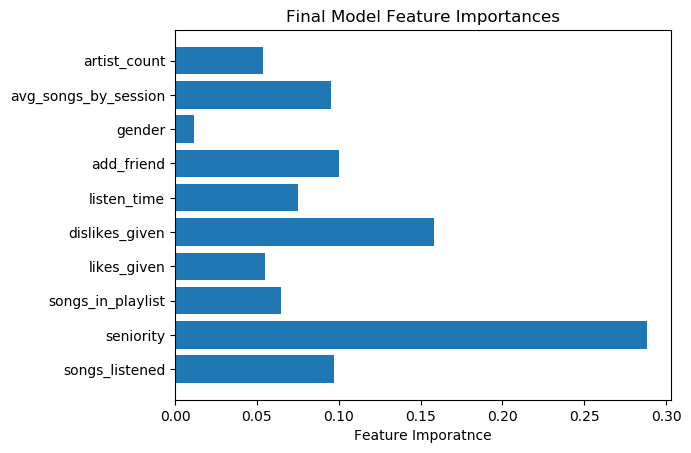

In [317]:
feature_importance = rf_final.featureImportances.values
cols = ['songs_listened'
       ,'seniority'
       ,'songs_in_playlist'
       ,'likes_given'
       ,'dislikes_given'
       ,'listen_time'
       ,'add_friend'
       ,'gender'
       ,'avg_songs_by_session'
       ,'artist_count']
y_pos = np.arange(len(cols))
 
plt.barh(y_pos
        ,feature_importance
        ,align = 'center')
plt.yticks(y_pos
          ,cols)
plt.xlabel('Feature Imporatnce')
plt.title('Final Model Feature Importances')

## <a class="anchor" id="conclusion">Part V : Conclusion</a>
User churn predicting is a real life challenge with many different important factors to account for.

### Reflection
Created project gives exposure to spark environment to analyze a large volume of data that personal laptop may not be capable to analyze.
By identifying customer with high chance to churn prior to the acutal losing, companies are able to use minimal cost to save customers by using targeted messages and offers.

### Improvements
#### Is seniority the best factor to account for?

We could argue about that. Senior users are already loyal to our platform and they prove it by sticking for so long with us. Potentially we could group users by their seniority and apply completely different strategies and factors to account for at different stage of loyalty.

#### Is this a time series related problem?

Yes we could assume so. There is much more to investigate on churn ratio and different seasonality patterns, holiday importance etc.

#### What about personality traits?

One could assume that, people who listen to metal genre are less likely to churn than the ones listen to pop music.

#### Geographical and cultural differences

Some countries and cultures are easier to make happy and vice versa.